<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab2_mdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Markov Decision Problems

# Exercise 1: Grid World
Compute the value funnction for the example 4.1 in the book.







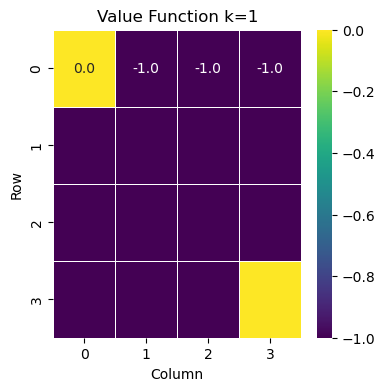

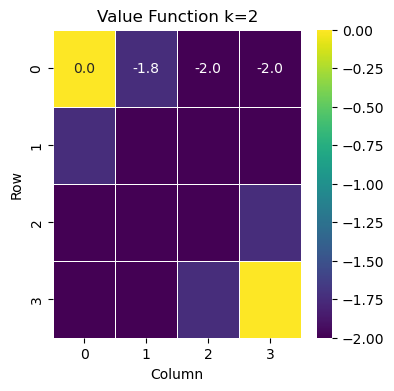

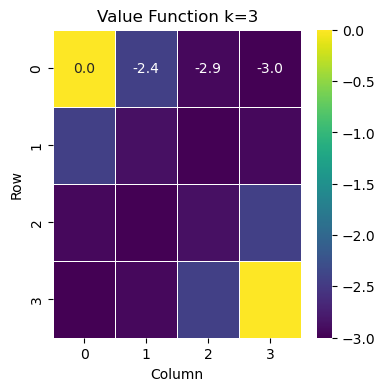

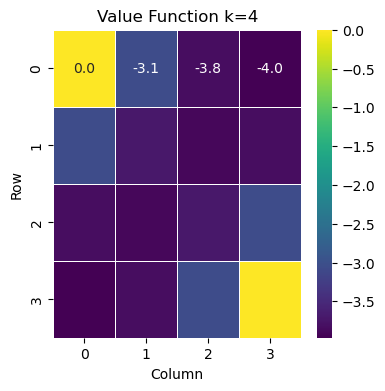

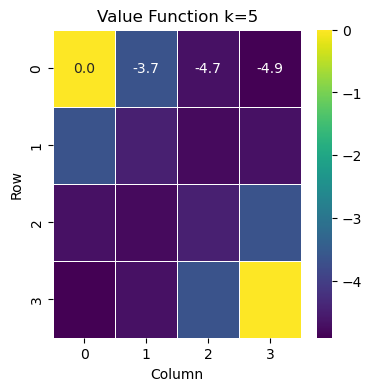

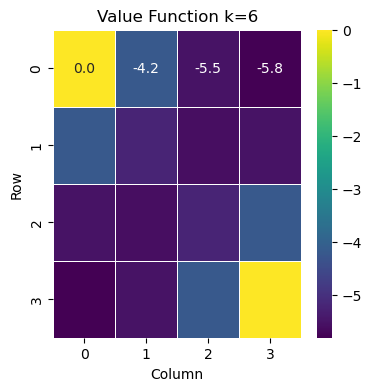

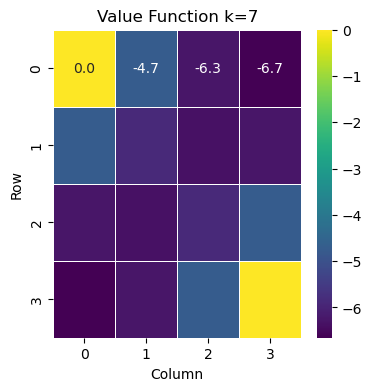

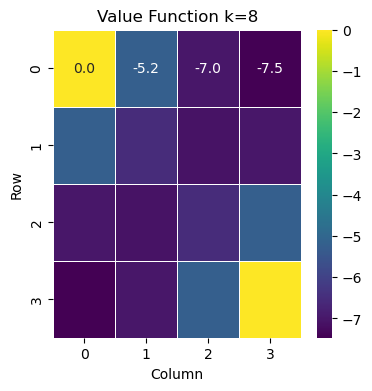

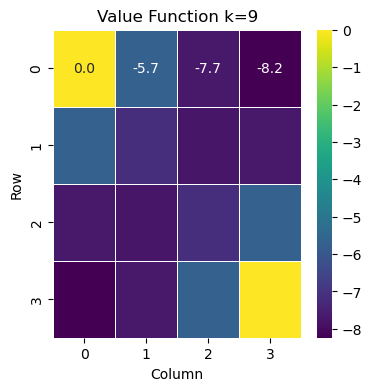

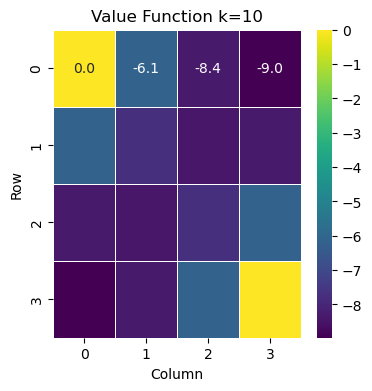

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

V = np.zeros(16)      # value estimates V(s)
gamma = 1.0          # discount factor
V_old = np.zeros(16)  # previous sweep values

A = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # U, D, L, R
pi = 0.25                                 # uniform random policy

k_ = 10  # number of steps

labels = np.arange(16).reshape(4, 4).astype(str)  # strings = show in every cell

for k in range(k_):            # number of sweeps
    for s in range(16):       # loop over states
        if s == 0 or s == 15: # terminal states fixed at 0
            continue

        # ----- Iterative Policy Evaluation update (Bellman expectation) -----
        r, c = divmod(s, 4)   # (row, col) in 4x4 grid
        v_new = 0.0
        for dr, dc in A:
            nr, nc = r + dr, c + dc
            # if action would leave grid, stay in the same state
            if nr < 0 or nr > 3 or nc < 0 or nc > 3:
                s_next = s
            else:
                s_next = 4 * nr + nc

            reward = -1  # per-step cost
            v_new += pi * (reward + gamma * V_old[s_next])

        V[s] = v_new
        # --------------------------------------------------------------------

    V_old = V.copy()

    # ------ PLOT ------
    V_grid = V.reshape((4, 4))
    plt.figure(figsize=(4, 4))
    sns.heatmap(V_grid, annot=True, cmap="viridis", fmt=".1f", linewidths=.5)
    plt.title("Value Function k=%d" % (k + 1))
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()


# Exercise 2: Grid World
Compute the optimal policy




V*:
 [[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]


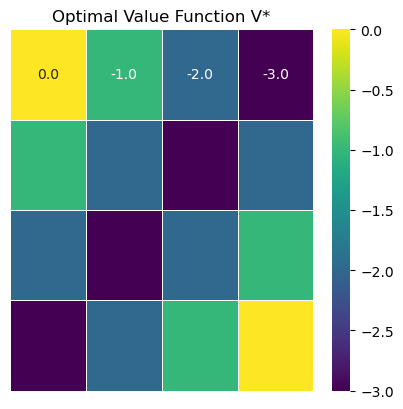

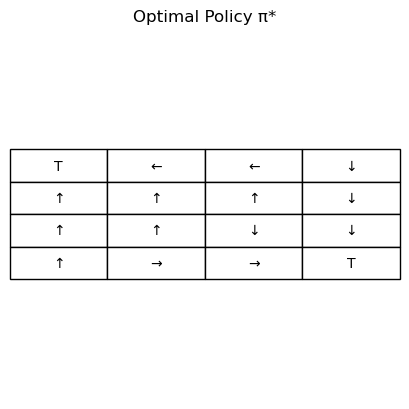

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----- Problem definition (4x4 Gridworld) -----
SIZE = 4
N = SIZE * SIZE
ACTIONS = [(-1,0), (1,0), (0,-1), (0,1)]        # U, D, L, R
ARROWS  = ['↑','↓','←','→']
TERMINAL = {0, N-1}
GAMMA = 1.0

def step(s, a):
    # Return (next_state, reward) for taking action a in state s.
    if s in TERMINAL:
        return s, 0
    r, c = divmod(s, SIZE)
    dr, dc = ACTIONS[a]
    nr, nc = r + dr, c + dc
    if 0 <= nr < SIZE and 0 <= nc < SIZE:
        return nr*SIZE + nc, -1
    return s, -1

def evaluate_policy(pi, theta=1e-10):
    """Iterative policy evaluation: solve V^pi."""
    V = np.zeros(N)
    while True:
        delta = 0.0
        for s in range(N):
            if s in TERMINAL: 
                continue
            v = sum(pi[s,a] * (step(s,a)[1] + GAMMA * V[step(s,a)[0]])
                    for a in range(4))
            delta = max(delta, abs(v - V[s]))
            V[s] = v
        if delta < theta:
            return V

def improve_policy(V):
    """Greedy improvement w.r.t. V -> deterministic policy."""
    pi = np.zeros((N,4))
    for s in range(N):
        if s in TERMINAL: 
            continue
        Q = [step(s,a)[1] + GAMMA * V[step(s,a)[0]] for a in range(4)]
        pi[s, np.argmax(Q)] = 1.0
    return pi

def policy_iteration():
    """Classic loop: evaluate -> improve until stable."""
    pi = np.ones((N,4)) / 4.0
    pi[list(TERMINAL)] = 0.0
    while True:
        V = evaluate_policy(pi)
        new_pi = improve_policy(V)
        if np.array_equal(new_pi, pi):   # policy-stable?
            return V, new_pi
        pi = new_pi

V_star, pi_star = policy_iteration()

# ----- Visualize -----
print("V*:\n", V_star.reshape(SIZE, SIZE))

plt.figure(figsize=(4.2,4.2))
sns.heatmap(V_star.reshape(SIZE,SIZE), annot=True, fmt=".1f",
            cmap="viridis", cbar=True, linewidths=.5,
            xticklabels=False, yticklabels=False)
plt.title("Optimal Value Function V*")
plt.tight_layout(); plt.show()

policy_grid = np.full((SIZE,SIZE), '', dtype=object)
for s in range(N):
    r,c = divmod(s, SIZE)
    policy_grid[r,c] = 'T' if s in TERMINAL else ARROWS[np.argmax(pi_star[s])]
plt.figure(figsize=(4.2,4.2))
tbl = plt.table(cellText=policy_grid, loc='center', cellLoc='center')
tbl.scale(1,1.7); plt.axis('off'); plt.title("Optimal Policy π*"); plt.tight_layout(); plt.show()


# Exercise 3: Grid World
In the following gym environment, compute the value function using Monte Carlo.

Run the following code in your local machine. You can run in on colab, but you will not see the animation.

In [6]:
## Install https://github.com/damat-le/gym-simplegrid
!pip install gym_simplegrid

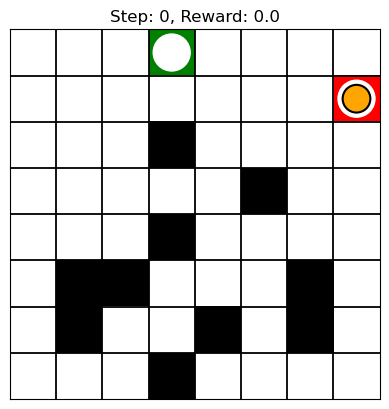

Location (0,7) t=0 reward=0.0
Location (0,7) t=1 reward=-1.0
Location (0,7) t=2 reward=-1.0
Location (0,7) t=3 reward=-1.0
Location (0,7) t=4 reward=-1.0
Location (0,7) t=5 reward=-1.0
Location (0,6) t=6 reward=0.0
Location (0,5) t=7 reward=0.0
Location (0,5) t=8 reward=-1.0
Location (1,5) t=9 reward=0.0


In [11]:

import gymnasium as gym
import gym_simplegrid

START_LOC = 15
GOAL_LOC = 3
# Define the initial location and the goal location in the grid.
# Each grid cell has an a number from 0 to 63.
options ={
    'start_loc': START_LOC,
    'goal_loc': GOAL_LOC
}

env = gym.make('SimpleGrid-8x8-v0', render_mode='human')
obs, info = env.reset(seed=1, options=options)
done = env.unwrapped.done

for t in range(10):
    if done:
        break
    action = env.action_space.sample()   # Random action
    obs, reward, done, _, info = env.step(action)

    grid_size = 8
    row = obs // grid_size
    col = obs % grid_size
    print("Location (", row, ",", col, ") t=",t, " reward=", reward, sep="")

# env.close()